In [ ]:
#word vectors 

In [74]:
from __future__ import absolute_import, division, print_function

In [75]:
import codecs 
import glob
import multiprocessing 
import os 
import pprint
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import re

In [76]:
import logging

In [77]:
#process the data 
#clean data

nltk.download('punkt') #pre-trained tokenizer
nltk.download('stopwords') #words like and,the,an,a,of (we gotta remove these)

[nltk_data] Downloading package punkt to /Users/simar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/simar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
book_filenames = sorted(glob.glob("thrones_books/*.txt"))
print(book_filename)

['thrones_books/got1.txt', 'thrones_books/got2.txt', 'thrones_books/got3.txt', 'thrones_books/got4.txt', 'thrones_books/got5.txt']


In [79]:
corpus_raw = u""
for bf in book_filenames:
    print("Reading '{0}'....".format(bf))
    with codecs.open(bf, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'thrones_books/got1.txt'....
Corpus is now 1770659 characters long

Reading 'thrones_books/got2.txt'....
Corpus is now 4071041 characters long

Reading 'thrones_books/got3.txt'....
Corpus is now 6391405 characters long

Reading 'thrones_books/got4.txt'....
Corpus is now 8107945 characters long

Reading 'thrones_books/got5.txt'....
Corpus is now 9719485 characters long



In [80]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [81]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [82]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words

In [83]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [84]:
print(raw_sentences[11])
print(sentence_to_wordlist(raw_sentences[11]))

Their droppings speckled the gargoyles that rose twelve feet tall on either side of him, a hellhound and a wyvern, two of the thousand that brooded over the walls of the ancient fortress.
['Their', 'droppings', 'speckled', 'the', 'gargoyles', 'that', 'rose', 'twelve', 'feet', 'tall', 'on', 'either', 'side', 'of', 'him', 'a', 'hellhound', 'and', 'a', 'wyvern', 'two', 'of', 'the', 'thousand', 'that', 'brooded', 'over', 'the', 'walls', 'of', 'the', 'ancient', 'fortress']


In [85]:
token_count = sum([len(sentence) for sentence in sentences])
print("the book corpus contains {0:,} tokens".format(token_count))

the book corpus contains 1,818,103 tokens


In [86]:
num_features = 300

min_word_count = 3

num_workers = multiprocessing.cpu_count()

context_size = 7

downsampling = 1e-3

seed = 1

In [87]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [88]:
thrones2vec.build_vocab(sentences)

In [101]:
l = len(thrones2vec.wv.vocab)
print(l)

17277


In [92]:
thrones2vec.train(sentences,total_words=thrones2vec.corpus_count,epochs=thrones2vec.epochs)

(7023172, 9090515)

In [93]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [94]:
thrones2vec.save(os.path.join("trained","thrones2vec.w2v"))

In [95]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained","thrones2vec.w2v"))

In [96]:
tsne = sklearn.manifold.TSNE(n_components=2,random_state=0)

In [97]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/Users/simar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [98]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [104]:
pts = pd.DataFrame(

    [
        
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
        
        
    ],
    columns = ["word", "x", "y"]



)

In [105]:
pts.head()

,word,x,y
0,This,-42.843971,-51.633190
1,edition,-31.104439,62.269070
2,the,-48.162666,-34.203621
3,complete,-17.303762,19.203344
4,of,-55.838696,-24.011444


In [106]:
sns.set_context("poster")

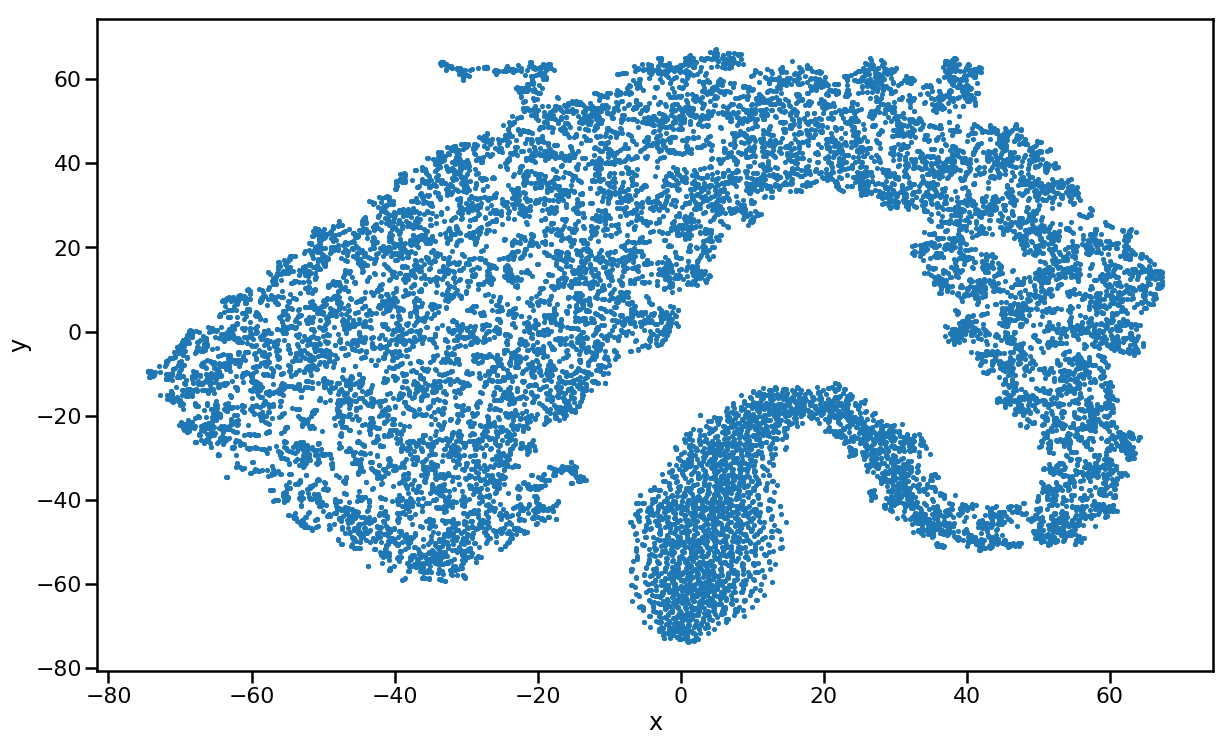

In [107]:
pts.plot.scatter("x", "y", s=10, figsize=(20,12))

In [116]:
def plot_region(x_bounds, y_bounds):
    slice = pts[
        
        (x_bounds[0] <= pts.x) &
        (pts.x <= x_bounds[1]) &
        (y_bounds[0] <= pts.y) &
        (pts.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10,8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

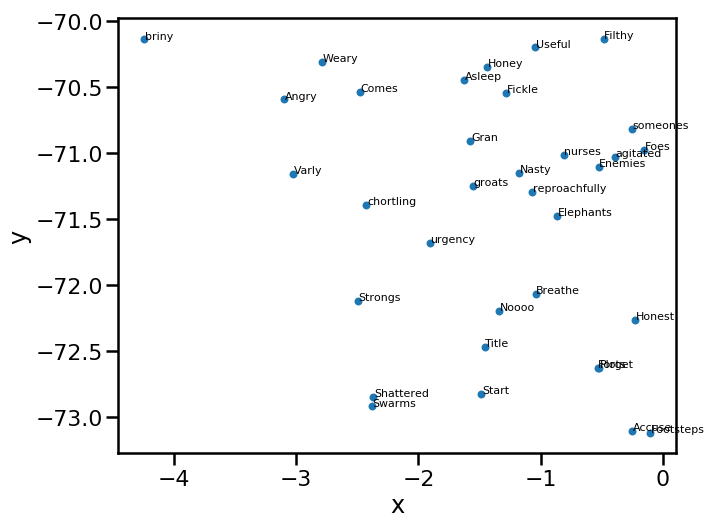

In [119]:
plot_region(x_bounds=(-5.0,0.0), y_bounds=(-75.0,-70.0))

In [120]:
thrones2vec.wv.most_similar("Stark")

[('Eddard', 0.9681118726730347),
 ('Robert', 0.9664338827133179),
 ('Arryn', 0.9543902277946472),
 ('Robb', 0.9462043046951294),
 ('Joffrey', 0.94275963306427),
 ('Greyjoy', 0.9408974647521973),
 ('North', 0.9375638365745544),
 ('Aerys', 0.9369207620620728),
 ('Edmure', 0.9331961870193481),
 ('Hand', 0.9328257441520691)]

In [121]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2,start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [122]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as heir is related to Riverrun
Jaime is related to sword, as Janos is related to wine
Arya is related to Nymeria, as Gendry is related to dragons


/Users/simar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Gendry'